#### Full disclaimer, I ripped tf outta this MIT lecture [here](https://ocw.mit.edu/courses/15-071-the-analytics-edge-spring-2017/pages/linear-regression/moneyball-the-power-of-sports-analytics/) where they did it in R

# ISBE 
* I - Inspect
* S - Select
* B - Build
* E - Evaluate 

In [4]:
# PANDAS IS FOR DATA WRANGLING
import pandas as pd
import numpy as np

# SEABORN IS A PLOTTING LIBRARY
import seaborn as sns

# MATPLOT LIB IS ALSO A PLOTTING LIBRARY
import matplotlib.pyplot as plt

# SKLEARN IS OUR MACHINE LEARNING PACKAGE
from sklearn.linear_model import LinearRegression

# IMPORT OUR RANDOM FOREST REGERSSOR
from sklearn.ensemble import RandomForestRegressor

# METRICS HELP US SCORE OUR MODEL
from sklearn import metrics

# HELP US SPLIT OUR DATA INTO TESTING A TRAINING
from sklearn.model_selection import train_test_split

# Good ol statsmodels
import statsmodels.api as sm

# Specific root mean squared error for stats models
from statsmodels.tools.eval_measures import rmse



In [5]:
# https://ocw.mit.edu/courses/15-071-the-analytics-edge-spring-2017/pages/linear-regression/moneyball-the-power-of-sports-analytics/video-2-making-it-to-the-playoffs/
# https://ocw.mit.edu/courses/15-071-the-analytics-edge-spring-2017/resources/video-3-predicting-runs-0/


def load_baseball_data(from_year=2002):
    df = pd.read_csv('data/baseball.csv')

    # Moneyball happened in 2002. 
    # So lets travel there and remove all data after then. 
    if from_year:
        c1 = df['Year'] < from_year 
        df = df[c1]
        df = df.reset_index(drop=True)
    df['runs_diff'] = df['RS'] - df['RA']
    print(df.shape)
    # print(df.Year.value_counts())
    df.head()
    return(df)


In [6]:
df = load_baseball_data()
df.head()

(902, 16)


,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG,runs_diff
0,ANA,AL,2001,691,730,75,0.327,0.405,0.261,0,NaN,NaN,162,0.331,0.412,-39
1,ARI,NL,2001,818,677,92,0.341,0.442,0.267,1,5.0,1.0,162,0.311,0.404,141
2,ATL,NL,2001,729,643,88,0.324,0.412,0.260,1,7.0,3.0,162,0.314,0.384,86
3,BAL,AL,2001,687,829,63,0.319,0.380,0.248,0,NaN,NaN,162,0.337,0.439,-142
4,BOS,AL,2001,772,745,82,0.334,0.439,0.266,0,NaN,NaN,161,0.329,0.393,27


### Data Dictionary of baseball dataset
* **Team**: Name of team
* **League**: League the team plays, either American League (AL) or National League (NL)
* **Year**: Year team played
* **RS**: Runs scored
* **RA**: Runs Allowed (scored by oppents)
* **Wins**: Total games won during given year
* **OBP**: On-Base Percentage
* **SLG**: Slugging Percentage
* **BA**: Batting percentage
* **Playoffs**: 1 if made it to the playoffs and 0 if not
* **RankSeason**: Team ranking in the season
* **RankPlayoffs**: Team ranking in the playoffs
* **G**: Total games played by team
* **OOBP**: Opponent On-Base Percentage
* **OSLG**: Opponent Slugging Percentage

In [8]:
def inspect(df):
    print('\n', '#'*79)
    print('CHECKING SHAPE AND SIZE:  df.shape', df.shape)
    print('\n', '#'*79)
    print( "CHEKCING NULLS", "print(df.isnull().sum())")
    print(df.isnull().sum())

    print('\n', '#'*79)
    print("CHECKING DUPES, df.duplicated().sum()")
    print(df.duplicated().sum())

    # plot_df = df.sample(frac=0.002)
    # sns.pairplot(plot_df)

inspect(df)



 ###############################################################################
CHECKING SHAPE AND SIZE:  df.shape (902, 16)

 ###############################################################################
CHEKCING NULLS print(df.isnull().sum())
Team              0
League            0
Year              0
RS                0
RA                0
W                 0
OBP               0
SLG               0
BA                0
Playoffs          0
RankSeason      748
RankPlayoffs    748
G                 0
OOBP            812
OSLG            812
runs_diff         0
dtype: int64

 ###############################################################################
CHECKING DUPES, df.duplicated().sum()
0


# Making the playoffs

### The Oakland A's, Paul DePodesta, estimated how many games it would take to make the playoffs:   _95 Wins_
---
So homeboy Peter something, gut feeling predicted you need to win 95 games to make the playoffs.  Lets inspect this hypothesis

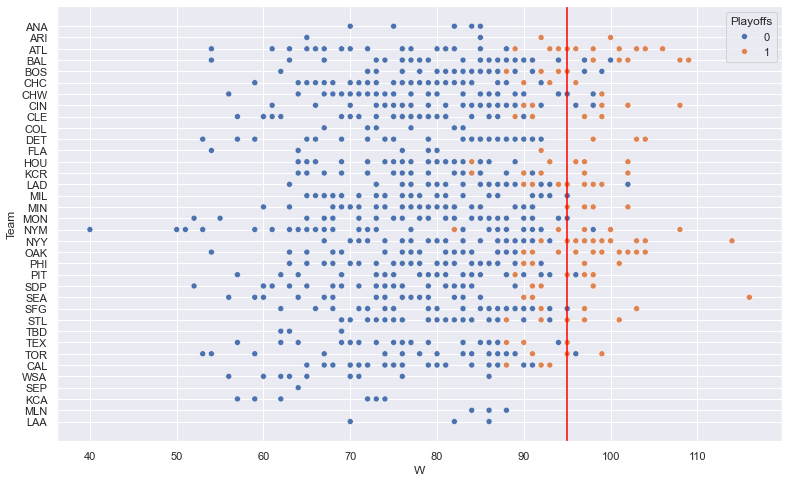

In [9]:
sns.set()
plt.figure(figsize=(13, 8))
ax = sns.scatterplot(df, x='W', y='Team', hue='Playoffs')
ax.axvline(x=95, color='red')
plt.show()

# Okay, how do you win.  Enter hypothesis here.  

#### Score more than is scored on you.

<AxesSubplot:xlabel='runs_diff', ylabel='W'>

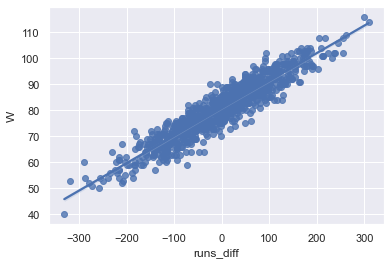

In [10]:
df['runs_diff'] = df['RS'] - df['RA']
sns.regplot(df, x='runs_diff', y='W')


### They calculated they needed to score 135 more runs than they allow to win 95 games.  

# Lets verify this using linear regression. 

In [13]:
import statsmodels.api as sm

X = df['runs_diff']
y = df['W']

# X = sm.add_constant(X)
X

0      -39
1      141
2       86
3     -142
4       27
      ... 
897    -54
898     80
899    188
900    110
901   -117
Name: runs_diff, Length: 902, dtype: int64

In [14]:
X = sm.add_constant(X)
X

,const,runs_diff
0,1.0,-39
1,1.0,141
2,1.0,86
3,1.0,-142
4,1.0,27
...,...,...
897,1.0,-54
898,1.0,80
899,1.0,188
900,1.0,110


In [15]:
import statsmodels.api as sm

X = df['runs_diff']
y = df['W']

X = sm.add_constant(X)

model_wins = sm.OLS(y, X).fit()
y_pred = model_wins.predict(X) 

results = model_wins.summary()
print(results)

root_mean_squared_error = rmse(y, y_pred)
print( y.mean(), root_mean_squared_error, ((root_mean_squared_error / y.mean())*100).round(2))

                            OLS Regression Results                            
Dep. Variable:                      W   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     6651.
Date:                Tue, 03 Oct 2023   Prob (F-statistic):               0.00
Time:                        19:39:33   Log-Likelihood:                -2515.5
No. Observations:                 902   AIC:                             5035.
Df Residuals:                     900   BIC:                             5045.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         80.8814      0.131    616.675      0.0

* Average Wins:  80.88 
* RMSE:  3.93 
* % off average by: %4.86


### Generated by ChatGPT:
    Average Error: On average, the model's predictions are about 3.93 wins away from the actual number of wins. This means, if your model predicted a team would win 85 games, you can expect the actual number of wins to be generally between 81.07 and 88.93.

# ChatGPT Suggestion: 
```Baseline Comparison: It can be helpful to compare the RMSE of the model to a naive or baseline prediction. For instance, if you always predicted the mean (80 wins) regardless of the input features, what would the RMSE be? If your model's RMSE is substantially lower than this baseline RMSE, it indicates that your model is capturing meaningful patterns in the data.```

In [16]:
# Making a new y_pred that every row is just the average wins of our data. 
naive_y_preds = [y.mean()]*len(y)

# finding the root mean squared of just our naive baseline 'model'
root_mean_squared_error = rmse(y, naive_y_preds)

# print that 
root_mean_squared_error


11.397100960562694

11.39 is much worse than our 3.93 so we can have some intuition that our model is better than just guessing the average. 

In [17]:
model_wins.params

const        80.881375
runs_diff     0.105766
dtype: float64

## Finding out how many runs diff we need to make 95 wins

In [18]:
coef_y_int = model_wins.params['const']
coef_runs_diff = model_wins.params['runs_diff']

print(coef_y_int, coef_runs_diff)

WINS = 95

# When is runs_diff make WINS >= 95
# coef_y_int + coef_runs_diff*??? >= 95
min_runs_diff = (WINS - coef_y_int) / coef_runs_diff
min_runs_diff


80.8813747228381 0.10576562244931809


133.48973844433633

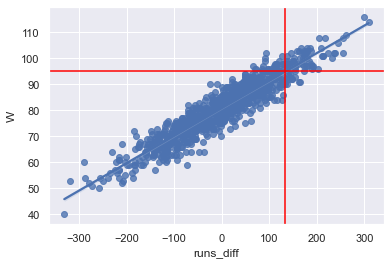

In [19]:
ax = sns.regplot(df, x='runs_diff', y='W' )
ax.axvline(x=min_runs_diff, color='red')
ax.axhline(y=WINS, color='red')
plt.show()

# We need to score 133.5 more runs than we allow to win 95 games to make the playoffs.  
### Okay.... now what?

# Okay, how do we increase runs_diff aka score more runs than we allow?

Everyone (in baseball) used to focus on Batting Average (BA) as the most important thing (or feature) when it came to winning.  

The Oakland A's thought different.  They used machine learning to find which were things (or features) acutally the most important when it came to winning. 


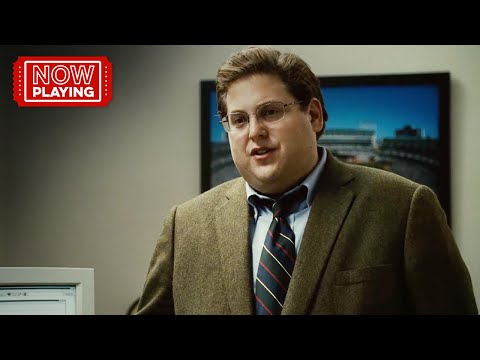

In [11]:
from IPython.display import YouTubeVideo

YouTubeVideo('unGSY5l76YQ', 800,500)

In [12]:
# from IPython.display import YouTubeVideo

# YouTubeVideo('3MjxoaynCmk', 800,500)

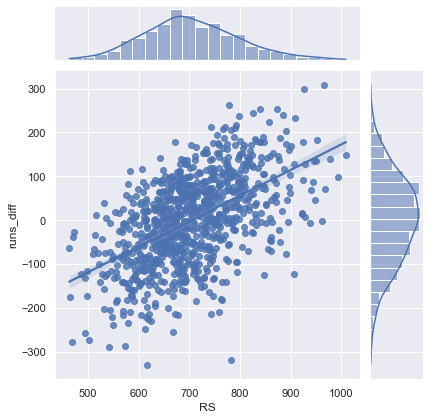

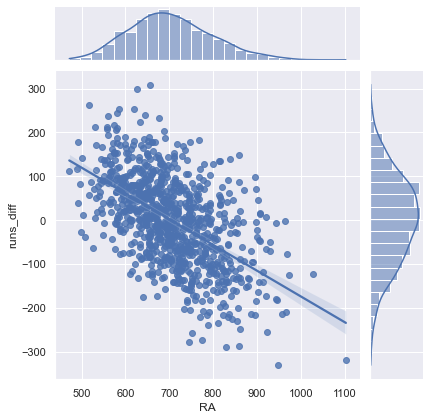

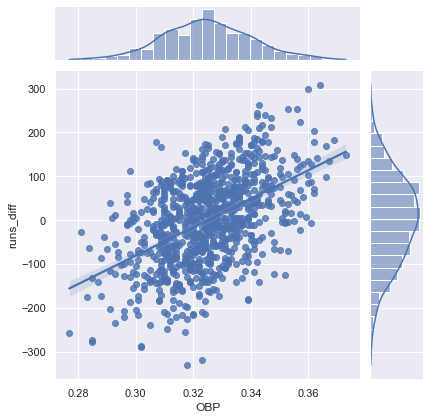

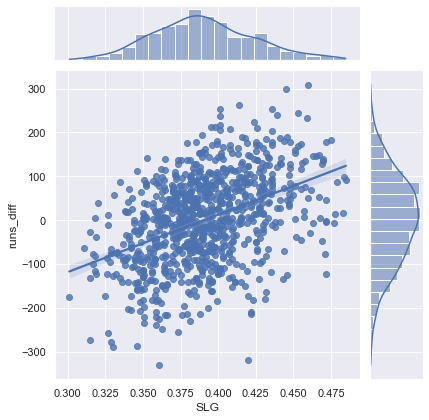

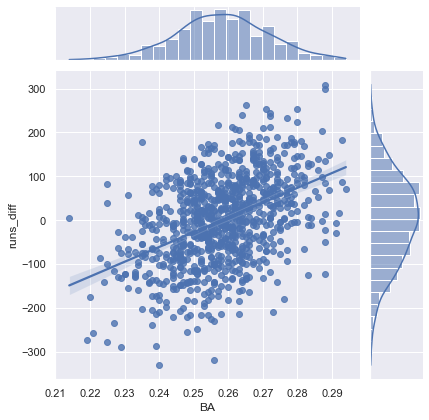

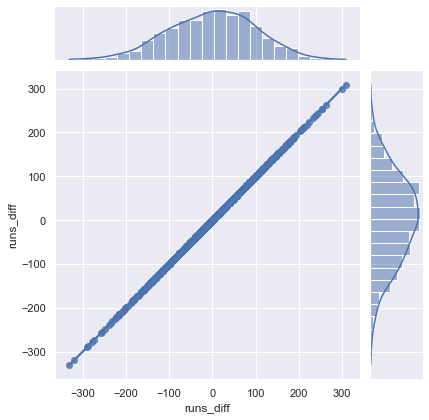

In [20]:
possible_cols = ['RS', 'RA', 'OBP', 'SLG', 'BA', 'runs_diff']
for col in possible_cols:
    sns.jointplot(x=col, y="runs_diff", data=df, kind="reg");

    # sns.relplot(data = df, x=col, y=target, height=5, aspect=1)

# Predicting Runs Scored

In [22]:
X = df[['OBP', 'SLG', 'BA']]
y = df['RS']

print( y.mean() )
X = sm.add_constant(X)

model_runs_scored = sm.OLS(y, X).fit()

print(model_runs_scored.summary())


y_pred = model_runs_scored.predict(X)

root_mean_squared_error = rmse(y, y_pred)
print(root_mean_squared_error)


root_mean_squared_error / y.mean()

703.8093126385809
                            OLS Regression Results                            
Dep. Variable:                     RS   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     3989.
Date:                Tue, 03 Oct 2023   Prob (F-statistic):               0.00
Time:                        20:00:57   Log-Likelihood:                -4170.2
No. Observations:                 902   AIC:                             8348.
Df Residuals:                     898   BIC:                             8368.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -788.4570     19.697  

0.035008723201582305

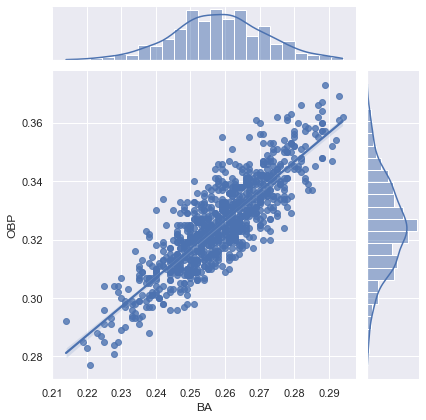

In [25]:
sns.jointplot(x='BA', y="OBP", data=df, kind="reg");

# Lets remove BA and see what happens...



In [26]:
X = df[['OBP', 'SLG']]
y = df['RS']

X = sm.add_constant(X)

model_runs_scored = sm.OLS(y, X).fit()
#predictions = mode_runs_scored.predict(X) 
print(model_runs_scored.summary())

                            OLS Regression Results                            
Dep. Variable:                     RS   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     5934.
Date:                Tue, 03 Oct 2023   Prob (F-statistic):               0.00
Time:                        20:04:01   Log-Likelihood:                -4174.2
No. Observations:                 902   AIC:                             8354.
Df Residuals:                     899   BIC:                             8369.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -804.6271     18.921    -42.526      0.0

In [27]:
# Sanity check, this should be close zero
model_runs_scored.resid.mean()

-4.0571832663623283e-13

array([[<AxesSubplot:title={'center':'OBP'}>,
        <AxesSubplot:title={'center':'SLG'}>],
       [<AxesSubplot:title={'center':'BA'}>, <AxesSubplot:>]],
      dtype=object)

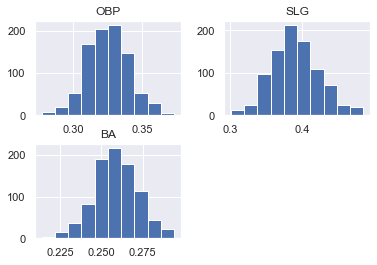

In [28]:
df[['OBP', 'SLG', 'BA']].hist()

In [29]:
df.head(1)

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG,runs_diff
0,ANA,AL,2001,691,730,75,0.327,0.405,0.261,0,NaN,NaN,162,0.331,0.412,-39


---
# Okay, lets see what affects RUNS ALLOWED the most.

In [30]:
df.isnull().sum()

Team              0
League            0
Year              0
RS                0
RA                0
W                 0
OBP               0
SLG               0
BA                0
Playoffs          0
RankSeason      748
RankPlayoffs    748
G                 0
OOBP            812
OSLG            812
runs_diff         0
dtype: int64

In [31]:
# Make a copy of the 
df_defense = df[['OOBP', 'OSLG', 'RA']].copy()
df_defense = df_defense.dropna()
print(df_defense.shape)


X = df_defense[['OOBP', 'OSLG']]
y = df_defense['RA']

X = sm.add_constant(X)

model_allowed_scored = sm.OLS(y, X).fit()
print(model_allowed_scored.summary())

(90, 3)
                            OLS Regression Results                            
Dep. Variable:                     RA   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     425.8
Date:                Tue, 03 Oct 2023   Prob (F-statistic):           1.16e-45
Time:                        20:07:06   Log-Likelihood:                -418.27
No. Observations:                  90   AIC:                             842.5
Df Residuals:                      87   BIC:                             850.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -837.3779     60.255    -13.897 

In [32]:

# -837.3779 + (0.324961 * 2913.5995) + (0.390412 * 1514.2860)

# Lets make projects for the okaland A's 2001 team

In [32]:
df = load_baseball_data()
df_oak = df[ df['Team'] == 'OAK' ].copy()

df_oak_2001 = df_oak[df_oak['Year']==2001].copy()

df_oak_2001['const'] = 1
df_oak_2001

(902, 16)


,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG,runs_diff,const
20,OAK,AL,2001,884,645,102,0.345,0.439,0.264,1,2.0,4.0,162,0.308,0.38,239,1


In [33]:
RS_2001 = model_runs_scored.predict(df_oak_2001[['const' ,'OBP', 'SLG']])
predicted_runs_scored = RS_2001.values[0]
print('Predicted runs scored for Oakland in 2001:', predicted_runs_scored)
# 


Predicted runs scored for Oakland in 2001: 835.6777844184776


In [34]:
RA_2001 = model_allowed_scored.predict( df_oak_2001[['const', 'OOBP', 'OSLG']] )
predicted_runs_allowed = RA_2001.values[0]
print('Predicted runs ALLOWED for Oakland in 2001:', predicted_runs_allowed)

Predicted runs ALLOWED for Oakland in 2001: 635.4394172160477


In [36]:
runs_diff = predicted_runs_scored - predicted_runs_allowed
runs_diff
WINS_2001 = model_wins.predict([1, runs_diff])

predicted_wins = WINS_2001[0]
print('Predicted WINS for Oakland in 2001:',predicted_wins )


Predicted WINS for Oakland in 2001: 102.05971026823822


In [37]:
df_oak_2001

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG,runs_diff,const
20,OAK,AL,2001,884,645,102,0.345,0.439,0.264,1,2.0,4.0,162,0.308,0.38,239,1


In [38]:
pred_dict = {
    'predicted_RS': predicted_runs_scored,
    'predicted_RA': predicted_runs_allowed,
    'predicted_W': predicted_wins
}
df_pred = pd.DataFrame.from_dict([pred_dict])
df_pred

,predicted_RS,predicted_RA,predicted_W
0,835.677784,635.439417,102.05971


In [39]:
load_baseball_data(from_year=None).head()

(1232, 16)


,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG,runs_diff
0,ARI,NL,2012,734,688,81,0.328,0.418,0.259,0,NaN,NaN,162,0.317,0.415,46
1,ATL,NL,2012,700,600,94,0.320,0.389,0.247,1,4.0,5.0,162,0.306,0.378,100
2,BAL,AL,2012,712,705,93,0.311,0.417,0.247,1,5.0,4.0,162,0.315,0.403,7
3,BOS,AL,2012,734,806,69,0.315,0.415,0.260,0,NaN,NaN,162,0.331,0.428,-72
4,CHC,NL,2012,613,759,61,0.302,0.378,0.240,0,NaN,NaN,162,0.335,0.424,-146


In [42]:
def predict_wins(team, year):
    df = load_baseball_data(from_year=None)
    df['const']=1
    df = df[ df['Team'] == team]
    df = df[ df['Year'] == year]
    
    
    runs_scored = model_runs_scored.predict(df[['const' ,'OBP', 'SLG']])
    runs_allowed = model_allowed_scored.predict( df[['const', 'OOBP', 'OSLG']] )
    runs_diff = runs_scored-runs_allowed
    pred = model_wins.predict([1, runs_diff])
    
    print(f"**** Runs Scored Predicted {runs_scored}****")
    print(f"**** Runs Scored Predicted {runs_allowed}****")
    print(f"***Runs Scored Predicted {pred}****")
    return(pred)

predict_wins("NYY", 2001)
    

(1232, 16)
**** Runs Scored Predicted 349    799.222702
dtype: float64****
**** Runs Scored Predicted 349    691.832559
dtype: float64****
***Runs Scored Predicted [349    92.23956
 dtype: float64 ]****


/Users/carlos/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:1153: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  exog = np.asarray(exog)


array([349    92.23956
       dtype: float64 ], dtype=object)

In [56]:
df = load_baseball_data(from_year=None)
df[df['Year'] == 2001][df['Team'] == 'NYY']

(1232, 16)


/var/folders/1x/3wmm3v4d5vbcjk0h_sjcn0h80000gn/T/ipykernel_70603/3251464144.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['Year'] == 2001][df['Team'] == 'NYY']


,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG,runs_diff
349,NYY,AL,2001,804,713,95,0.334,0.435,0.267,1,3.0,2.0,161,0.318,0.398,91


# THE GOTCHAS, THE CHECKS, THE 'HOUSE CLEANING'

# Checking Assumptons
1. Linearity
2. Homoscedasticity
3. Normality of Errors
4. Multicollinearity
5. Outliers

## Checking Linearity

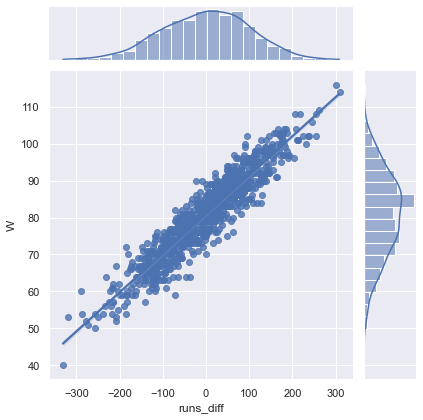

In [29]:
sns.jointplot(x="runs_diff", y="W", data=df, kind="reg");

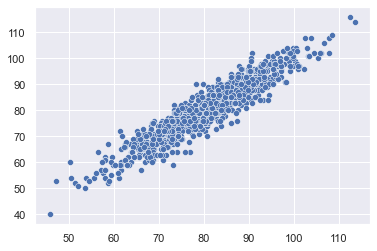

In [30]:
import statsmodels.api as sm

X = df['runs_diff']
y = df['W']

X = sm.add_constant(X)

model_wins = sm.OLS(y, X).fit()
y_pred = model_wins.predict(X) 

sns.scatterplot(y=y.values, x=y_pred.values);

# Checking Homoscedasticy


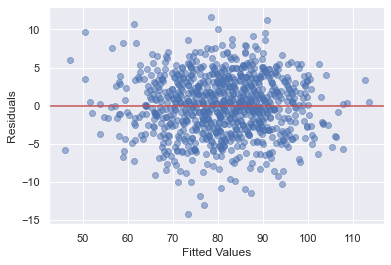

In [31]:
## Code taken / modified via tutorial below
# https://www.einblick.ai/python-code-examples/residual-plots-heteroskedasticity-test/


# This is for the wins model
plt.scatter(model_wins.fittedvalues, model_wins.resid, alpha=0.5)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.axhline(y = 0, color = 'r')
plt.show()

### For the runs_scored model

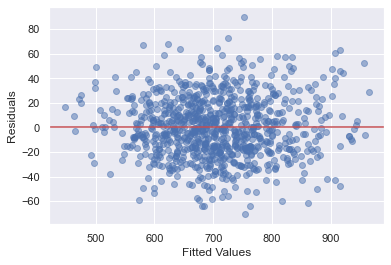

In [32]:

plt.scatter(model_runs_scored.fittedvalues, model_runs_scored.resid, alpha=0.5)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.axhline(y = 0, color = 'r')
plt.show()

### For the runs_allowed model

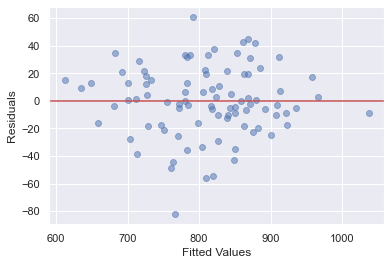

In [33]:

plt.scatter(model_allowed_scored.fittedvalues, model_allowed_scored.resid, alpha=0.5)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.axhline(y = 0, color = 'r')
plt.show()

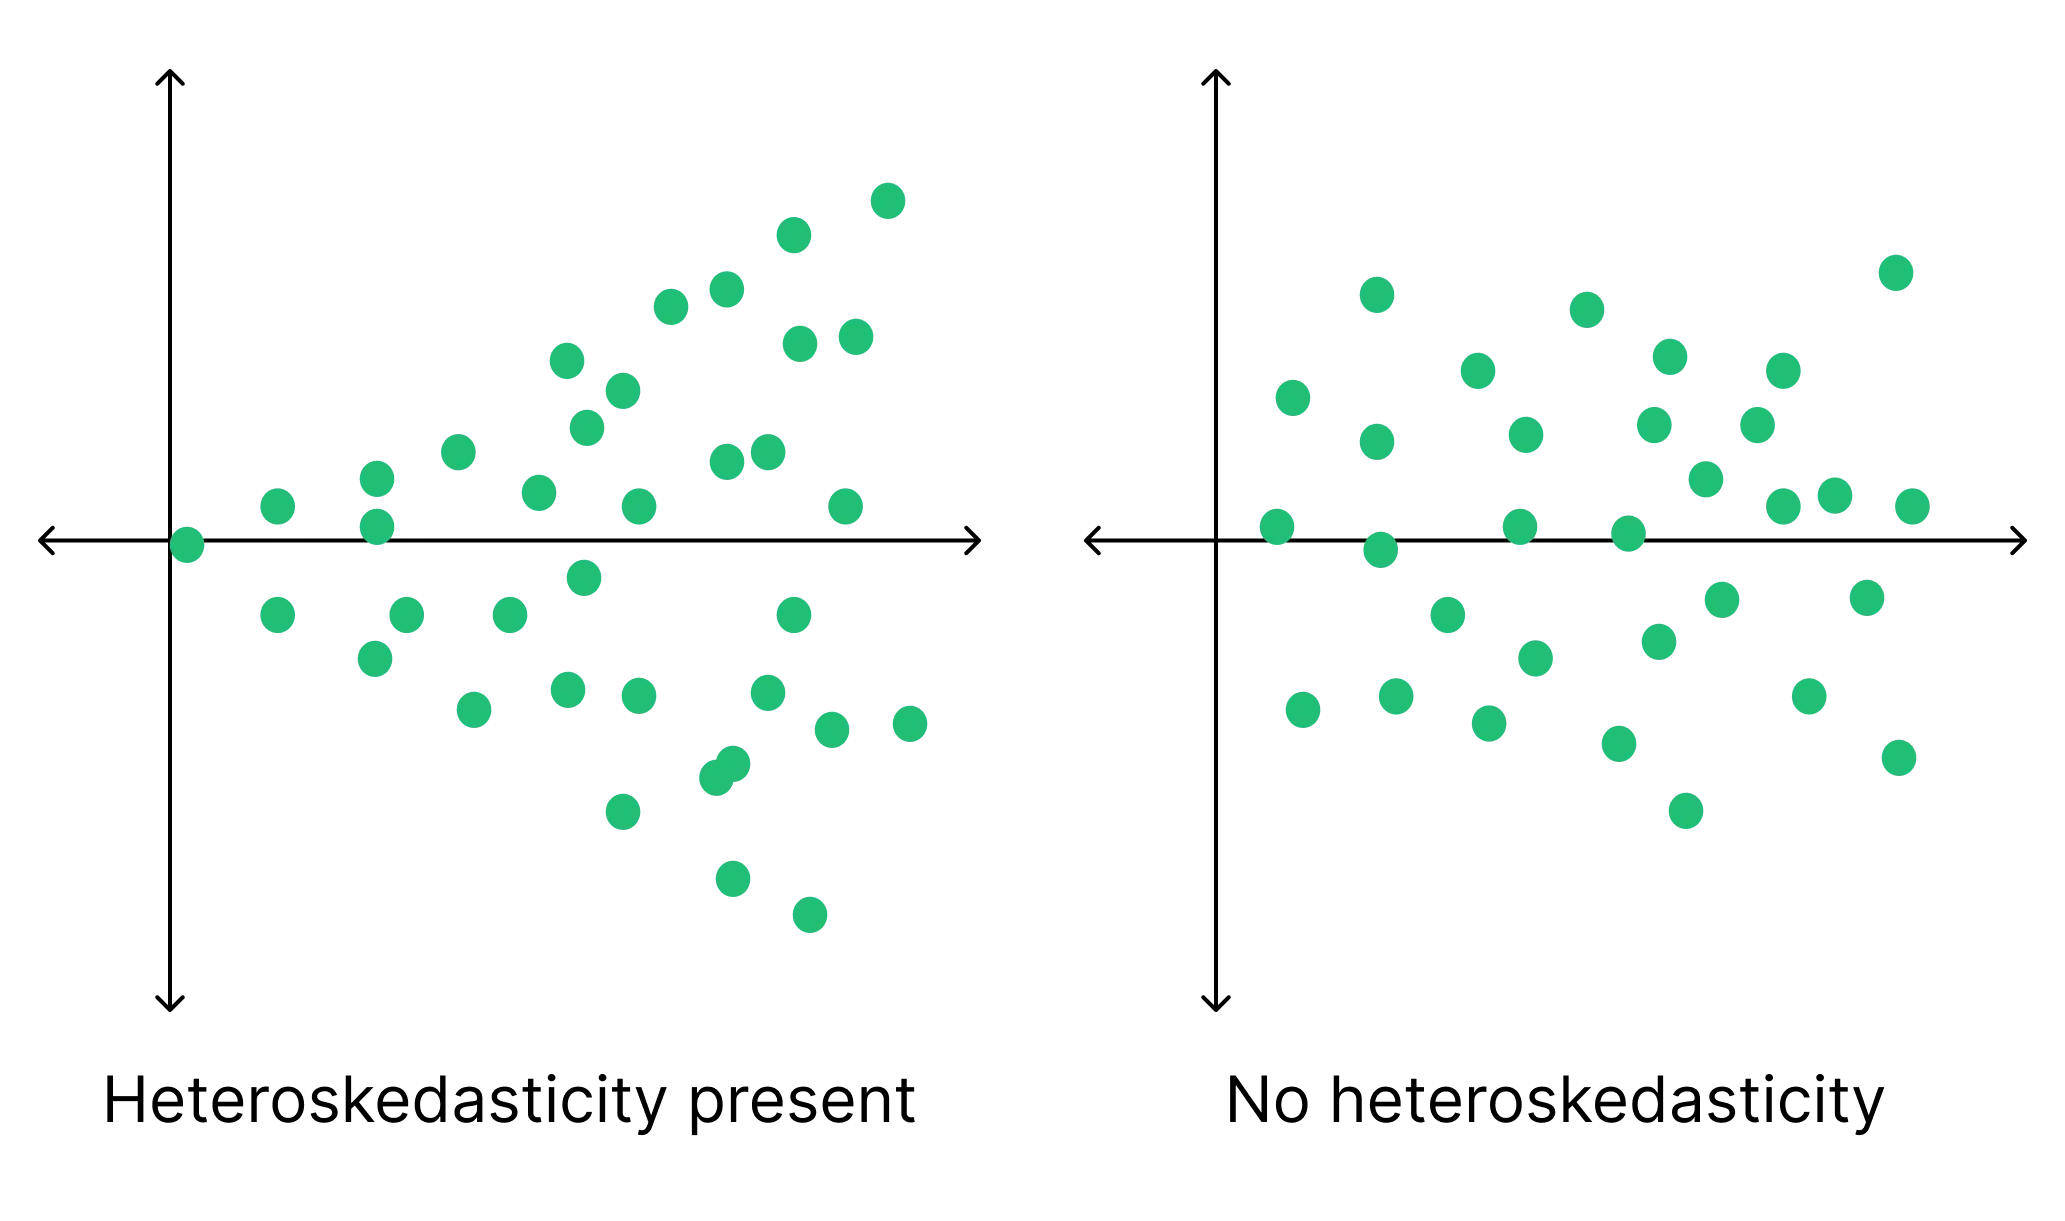

### Normal distribution of the error aka the resiudals

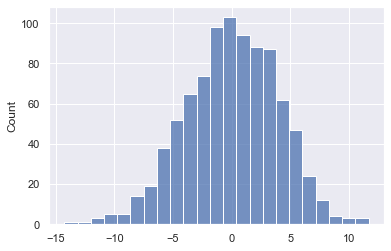

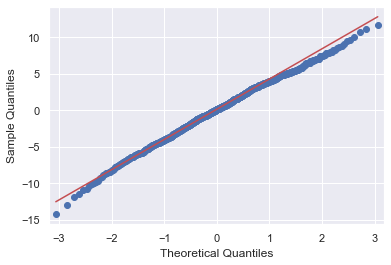

In [34]:
from statsmodels.api import qqplot

# predictions
y_pred = model_wins.predict(X)

# the truth - the prediction
residuals =  y.values - y_pred.values 

# histogram
sns.histplot(residuals)


# qq plot
qqplot(residuals, line='q');

# Checking for Multicollinearity 

### Member this summary report and why i asked if it looked strange?


In [35]:
X = df[['OBP', 'SLG', 'BA']]
y = df['RS']

print( y.mean() )
X = sm.add_constant(X)

model_runs_scored_multicolin = sm.OLS(y, X).fit()



y_pred = model_runs_scored_multicolin.predict(X)

root_mean_squared_error = rmse(y, y_pred)
print(root_mean_squared_error)


root_mean_squared_error / y.mean()

print(model_runs_scored_multicolin.summary())

703.8093126385809
24.63946541285998
                            OLS Regression Results                            
Dep. Variable:                     RS   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     3989.
Date:                Tue, 03 Oct 2023   Prob (F-statistic):               0.00
Time:                        17:36:56   Log-Likelihood:                -4170.2
No. Observations:                 902   AIC:                             8348.
Df Residuals:                     898   BIC:                             8368.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -788

# This looks strange because batting average shouldn't be NEGATIVELY affecting Runs scored... 
## Why is this happening.  

![word_of_the_day](https://i.imgflip.com/80a3lx.jpg)

In [60]:
selected_features = [
 'OBP',
 'SLG',
 'BA']
df[selected_features].corr()

,OBP,SLG,BA
OBP,1.000000,0.790910,0.851958
SLG,0.790910,1.000000,0.790481
BA,0.851958,0.790481,1.000000


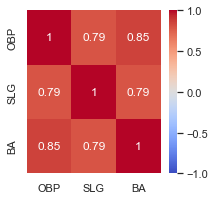

In [61]:
selected_features = [
 'OBP',
 'SLG',
 'BA',]

plt.figure(figsize = (3,3))

ax = sns.heatmap( df[selected_features].corr(), 
            annot=True, 
            cmap='coolwarm',
            vmin=-1, vmax=1);

In [62]:
# https://towardsdatascience.com/verifying-the-assumptions-of-linear-regression-in-python-and-r-f4cd2907d4c0
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
pd.DataFrame(columns=X.columns, data=[vif])

,const,OOBP,OSLG
0,495.736774,2.735629,2.735629


## [Another Homoscedasticity Test](https://towardsdatascience.com/verifying-the-assumptions-of-linear-regression-in-python-and-r-f4cd2907d4c0)

```We can also use two statistical tests: Breusch-Pagan and Goldfeld-Quandt. In both of them, the null hypothesis assumes homoscedasticity and a p-value below a certain level (like 0.05) indicates we should reject the null in favor of heteroscedasticity.```

In [63]:
# https://towardsdatascience.com/verifying-the-assumptions-of-linear-regression-in-python-and-r-f4cd2907d4c0
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

def homoscedasticity_test(model):
    '''
    Function for testing the homoscedasticity of residuals in a linear regression model.
    It plots residuals and standardized residuals vs. fitted values and runs Breusch-Pagan and Goldfeld-Quandt tests.
    
    Args:
    * model - fitted OLS model from statsmodels
    '''
    fitted_vals = model.predict()
    resids = model.resid
    resids_standardized = model.get_influence().resid_studentized_internal

    fig, ax = plt.subplots(1,2)

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Residuals vs Fitted', fontsize=16)
    ax[0].set(xlabel='Fitted Values', ylabel='Residuals')

    sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Scale-Location', fontsize=16)
    ax[1].set(xlabel='Fitted Values', ylabel='sqrt(abs(Residuals))')

    bp_test = pd.DataFrame(sms.het_breuschpagan(resids, model.model.exog), 
                           columns=['value'],
                           index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])

    gq_test = pd.DataFrame(sms.het_goldfeldquandt(resids, model.model.exog)[:-1],
                           columns=['value'],
                           index=['F statistic', 'p-value'])

    print('\n Breusch-Pagan test ----')
    print(bp_test)
    print('\n Goldfeld-Quandt test ----')
    print(gq_test)
    print('\n Residuals plots ----')

homoscedasticity_test(model_runs_scored_multicolin)

NameError: name 'model_runs_scored_multicolin' is not defined

In [ ]:
homoscedasticity_test(model_runs_scored)

# Lets just do this in SK-Learn to sanity check our results

In [ ]:
df = load_baseball_data()

X = df[['runs_diff']]
y = df['W']
print(y.mean())


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
lr_wins = LinearRegression()

lr_wins.fit(X_train, y_train)

y_pred = lr_wins.predict(X_test)


r_squared = metrics.r2_score(y_test, y_pred)
print('R-Squared Score:', r_squared)

mse = metrics.mean_squared_error(y_test, y_pred)

rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)
np.sqrt(mse), rmse



In [ ]:
# Predicting Runs Scored
df = load_baseball_data()

## Runs Scored
X = df[['OBP', 'SLG', 'BA']]
y = df['RS']
print(y.mean()) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
lr_runs_scored = LinearRegression()

lr_runs_scored.fit(X_train, y_train)

y_pred = lr_runs_scored.predict(X_test)


r_squared = metrics.r2_score(y_test, y_pred)
print('R-Squared Score:', r_squared)

metrics.mean_squared_error(y_test, y_pred, squared=False)



In [ ]:
# Predicting Runs Allowed
df = load_baseball_data()

df_defense = df[['OOBP', 'OSLG', 'RA']].copy()
print(df_defense.isnull().sum())
df_defense = df_defense.dropna()
print(df_defense.shape)

X = df_defense[['OOBP', 'OSLG']]
y = df_defense['RA']
print(y.mean())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
lr_runs_allowed = LinearRegression()

lr_runs_allowed.fit(X_train, y_train)

y_pred = lr_runs_allowed.predict(X_test)


r_squared = metrics.r2_score(y_test, y_pred)
print('R-Squared Score:', r_squared)

metrics.mean_squared_error(y_test, y_pred, squared=False)


In [ ]:
# # https://www.einblick.ai/python-code-examples/residual-plots-heteroskedasticity-test/
# fig = plt.figure(figsize = (8,6))

# # Create regression plots for specified X variable
# sm.graphics.plot_regress_exog(model_wins, 'runs_diff', fig = fig)
# plt.show()

# BELOW ARE RABBIT HOLES

In [ ]:
# # Multicolin trick
# # https://youtu.be/0m-rs2M7K-Y?si=OWvx8pzTNfpdsRYj&t=1720


# X = df[['OBP', 'SLG', 'BA']]
# y = X.pop("OBP")
# X = sm.add_constant(X)

# test_model = sm.OLS(y, X).fit()
# #predictions = mode_runs_scored.predict(X) 
# test_model.summary()

# T = 1 - test_model.rsquared
# T

# VIF = 1 / T
# VIF
# infulence = test_model.get_influence()
# infulence.summary_table()

In [ ]:
# df = pd.read_csv('data/bb.csv')
# df_oak = df[ df['Team'] == 'OAK' ].copy()

# df_oak_2001 = df_oak[df_oak['Year']==2001].copy()
# df_oak

In [ ]:



## RABBIT HOLE
# # from sklearn.preprocessing import StandardScaler
# # X = df[['OBP', 'SLG']]
# # y = df['RS']


# # scaler = StandardScaler()
# # scaler.fit(df[['OBP', 'SLG']])

# # X = scaler.transform(df[['OBP', 'SLG']])

# # dfX = pd.DataFrame(X)
# # dfX.columns = ['OPB', 'SLG']
# # dfX.hist()
# # X = None
# # X = sm.add_constant(dfX)
# # X.shape
# # # mode_runs_scored = sm.OLS(y, X).fit()
# # # #predictions = mode_runs_scored.predict(X) 
# # # mode_runs_scored.summary()




# from sklearn.preprocessing import StandardScaler
# X = df[['OBP', 'SLG']]
# y = df['RS']


# scaler = StandardScaler()
# scaler.fit(X)

# X = scaler.transform(X)
# X = pd.DataFrame(X)
# X.columns = ['OPB', 'SLG']
# X = sm.add_constant(X)
# X
# mode_runs_scored = sm.OLS(y, X).fit()
# # # predictions = mode_runs_scored.predict(X) 
# mode_runs_scored.summary()

In [ ]:
# from sklearn.preprocessing import Normalizer
# df = df.reset_index(drop=True)
# X = df[['OBP', 'SLG', 'RS']]
# y = df['RS']

# transformer = Normalizer().fit(X)  # fit does nothing.
# X = transformer.transform(X)
# X = pd.DataFrame(X)
# X.columns = ['OPB', 'SLG', 'RS']
# X = sm.add_constant(X)
# y = X.pop('RS')

# mode_runs_scored = sm.OLS(y, X).fit()
# mode_runs_scored.summary()

In [ ]:
# from sklearn.preprocessing import StandardScaler
# X = df[['OBP', 'SLG']]
# y = df['RS']


# scaler = StandardScaler()
# scaler.fit(X)

# X = scaler.transform(X)
# X = pd.DataFrame(X)
# X.columns = ['OBP', 'SLG']
# X

In [ ]:
# from sklearn.preprocessing import StandardScaler
# jobp = df[['OBP']]
# y = df['RS']


# scaler = StandardScaler()
# scaler.fit(jobp)

# jobp = scaler.transform(jobp)
# jobp = pd.DataFrame(jobp)
# jobp.columns = ['OBP']
# jobp
# jobp['OBP'] == X['OBP']